In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv

In [2]:
train_df = pd.read_csv("train_2_pr.csv")
test_df = pd.read_csv("test_2.csv")



In [3]:
# Writing a function to prepreocess the data
def preprocess_data(df, is_train=True):
    df = df.copy()
    
    # First I need to convert the timestamps into date time format
    df['send_timestamp'] = pd.to_datetime(df['send_timestamp'])
    
    # Extracting the features from timestamp
    df['send_hour'] = df['send_timestamp'].dt.hour
    df['send_day'] = df['send_timestamp'].dt.day
    df['send_month'] = df['send_timestamp'].dt.month
    df['send_year'] = df['send_timestamp'].dt.year
    
    # Here, I drop the timestamp column as it is redundant
    df.drop(columns=['send_timestamp'], inplace=True)
    
    # Now, I encode the categorical variables
    label_encoders = {}
    categorical_cols = ['pick_up_point', 'drop_off_point', 'source_country', 
                        'destination_country', 'shipment_mode', 'shipping_company', 'selected']
    
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    # Shipment ID is an identifier, so I drop it to prevent confusion
    df.drop(columns=['shipment_id', 'Unnamed: 0'], inplace=True)
    
    # Here, I use Standard Scaler to scale the numerical features
    scaler = StandardScaler()
    numeric_cols = ['freight_cost', 'gross_weight', 'shipment_charges', 'send_hour', 'send_day', 'send_month', 'send_year']
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Then, I split the feature variables and the target variable (only for the training data)
    if is_train:
        X = df.drop(columns=['shipping_time'])
        y = df['shipping_time']
        return X, y, label_encoders, scaler
    else:
        return df

# Preprocessing the training data using the function: preprocess_data
X_train, y_train, label_encoders, scaler = preprocess_data(train_df, is_train=True)

# Next, I preprocess the test data using the function: preprocess_data
X_test = preprocess_data(test_df, is_train=False)

# Making sure the test set has the same features as the training set
X_test = X_test[X_train.columns]

print("Data Preprocessing Complete!")
print(X_train.head())



Data Preprocessing Complete!
   pick_up_point  drop_off_point  source_country  destination_country  \
0              0               1               0                    1   
1              0               1               0                    1   
2              0               1               0                    1   
3              0               1               0                    1   
4              0               1               0                    1   

   freight_cost  gross_weight  shipment_charges  shipment_mode  \
0     -0.502717     -0.473210         -0.951330              0   
1     -1.077047     -0.670686          0.220913              1   
2     -0.966450     -0.674635         -0.951330              0   
3      0.626539      0.092360          1.393156              0   
4      0.589673      0.831709         -0.951330              0   

   shipping_company  selected  send_hour  send_day  send_month  send_year  
0                 2         0  -1.202865 -0.678716   -0.113

In [4]:
# Group data by 'shipment_mode'
# Now, I group the data based on 'shipment mode'
shipment_modes = X_train['shipment_mode'].unique()



In [5]:


# Convert dataset to tensors
X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# Define edges (connect shipment points and modes)
edges = []  # This should contain relationships (e.g., from pickup to destination)
for i in range(len(X_train)):
    edges.append([X_train.iloc[i]['pick_up_point'], X_train.iloc[i]['drop_off_point']])

edge_index = torch.tensor(edges, dtype=torch.long).T  # Convert to tensor

# Create PyTorch Geometric Graph Object
data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)


C:\Users\R\AppData\Local\Temp\ipykernel_1200\2222500264.py:10: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor(edges, dtype=torch.long).T  # Convert to tensor


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv


In [7]:
# Dictionary to store results
xgb_results_by_mode = {}

# Train Optimized XGBoost for each shipment mode
for mode in shipment_modes:
    print(f"Training XGBoost for Shipment Mode: {mode}")

    # Filter data for the current shipment mode
    X_train_mode = X_train[X_train['shipment_mode'] == mode].drop(columns=['shipment_mode'])
    y_train_mode = y_train[X_train['shipment_mode'] == mode]
    X_test_mode = X_test[X_test['shipment_mode'] == mode].drop(columns=['shipment_mode'], errors='ignore')

    # Train XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42)
    xgb_model.fit(X_train_mode, y_train_mode)

    # Predict on test set
    y_pred_xgb = xgb_model.predict(X_test_mode)

    # Predict on train set for evaluation
    y_train_pred_xgb = xgb_model.predict(X_train_mode)

    # Evaluate performance
    xgb_mae = mean_absolute_error(y_train_mode, y_train_pred_xgb)
    xgb_rmse = mean_squared_error(y_train_mode, y_train_pred_xgb) ** 0.5
    xgb_r2 = r2_score(y_train_mode, y_train_pred_xgb)

    # Store results
    xgb_results_by_mode[mode] = {
        "MAE": xgb_mae,
        "RMSE": xgb_rmse,
        "R2 Score": xgb_r2,
        "Predictions": y_pred_xgb[:10]
    }

# Convert results to DataFrame and display
xgb_results_df = pd.DataFrame(xgb_results_by_mode).T
print("Optimized XGBoost Results:")
print(xgb_results_df)



Training XGBoost for Shipment Mode: 0
Training XGBoost for Shipment Mode: 1
Optimized XGBoost Results:
        MAE      RMSE  R2 Score  \
0  0.050361  0.063397  0.732266   
1  3.742116  4.630676  0.774068   

                                         Predictions  
0  [5.209595, 5.2602715, 5.1449647, 5.193505, 5.2...  
1  [12.771855, 18.290365, 24.098497, 27.00506, 19...  


📋 Model Evaluation Summary:
           MAE   RMSE  R² Score
XGBoost   4.23   6.87      0.57
LightGBM  4.14   6.88      0.57
CatBoost  4.32   6.92      0.55
GRU       7.21  12.10      0.22
GNN       8.49  14.60     -0.94


C:\Users\R\AppData\Local\Temp\ipykernel_1200\3651211300.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='viridis')
C:\Users\R\AppData\Local\Temp\ipykernel_1200\3651211300.py:30: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\R\anaconda3\envs\logistic\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


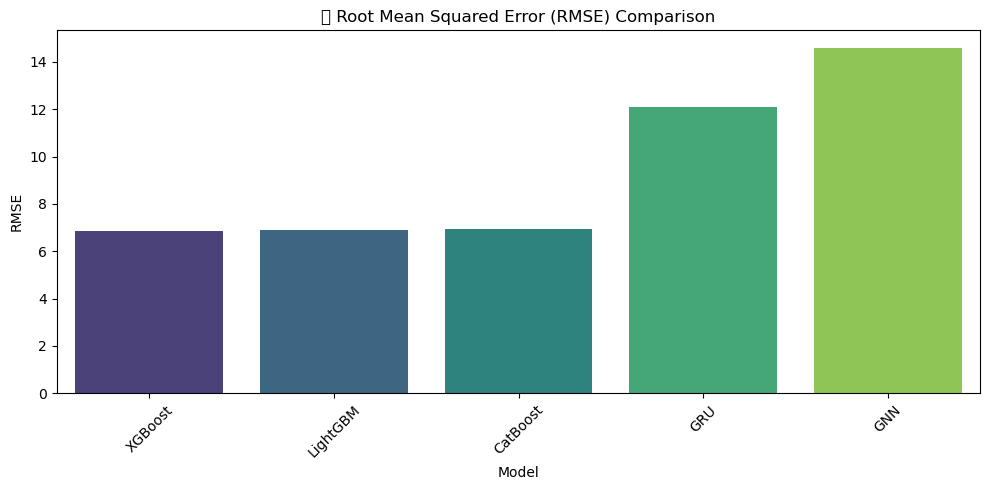

C:\Users\R\AppData\Local\Temp\ipykernel_1200\3651211300.py:44: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\R\anaconda3\envs\logistic\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


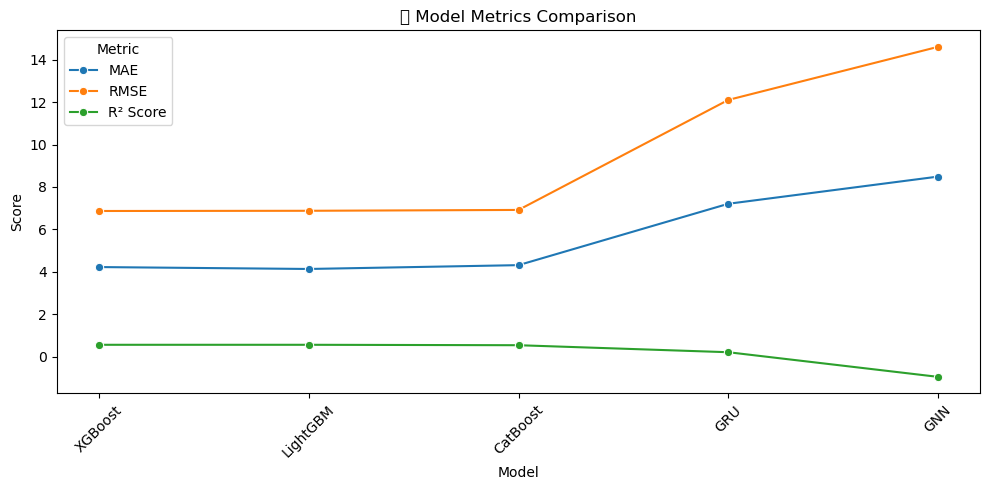

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample performance dictionary – replace with your actual result dictionaries
model_results = {
    'XGBoost': {'MAE': 4.23, 'RMSE': 6.87, 'R2': 0.57},
    'LightGBM': {'MAE': 4.14, 'RMSE': 6.88, 'R2': 0.57},
    'CatBoost': {'MAE': 4.32, 'RMSE': 6.92, 'R2': 0.55},
    'GRU': {'MAE': 7.21, 'RMSE': 12.10, 'R2': 0.22},
    'GNN': {'MAE': 8.49, 'RMSE': 14.60, 'R2': -0.94}
}

# Convert to DataFrame
results_df = pd.DataFrame(model_results).T
results_df.columns = ['MAE', 'RMSE', 'R² Score']
results_df = results_df.sort_values(by='RMSE')

# 📊 Print the performance table
print("📋 Model Evaluation Summary:")
print(results_df)

# 📊 Plot 1: Barplot of RMSE for all models
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='viridis')
plt.title("📉 Root Mean Squared Error (RMSE) Comparison")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📊 Plot 2: Lineplot of all metrics
results_df.reset_index(inplace=True)
results_df = pd.melt(results_df, id_vars='index', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='index', y='Score', hue='Metric', marker='o')
plt.title("📈 Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


In [9]:


# Preprocess training data
X, y, label_encoders, scaler = preprocess_data(train_df, is_train=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check if the data is split correctly
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

#  Define LightGBM hyperparameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 8,
    'num_leaves': 31,
    'min_data_in_leaf': 10,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': -1
}

# Convert Data to LightGBM Dataset Format
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Use `callbacks=[lgb.early_stopping(50)]` instead of `early_stopping_rounds=50`
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=500,  # Equivalent to `n_estimators`
    valid_sets=[valid_data],  # Validation data for early stopping
    callbacks=[lgb.early_stopping(50)],  #  Correct way to apply early stopping
)

print("\nLightGBM Training Completed")

X_train Shape: (4091, 14), y_train Shape: (4091,)
X_test Shape: (1023, 14), y_test Shape: (1023,)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 6.88394

LightGBM Training Completed


In [10]:


# Dictionary to store LightGBM results
lgbm_results_by_mode = {}

# Train LightGBM for each shipment mode
for mode in shipment_modes:
    print(f"Training LightGBM for Shipment Mode: {mode}")

    # Filter data
    X_train_mode = X_train[X_train['shipment_mode'] == mode].drop(columns=['shipment_mode'])
    y_train_mode = y_train[X_train['shipment_mode'] == mode]
    X_test_mode = X_test[X_test['shipment_mode'] == mode].drop(columns=['shipment_mode'], errors='ignore')

    # Train LightGBM model
    lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42)
    lgbm_model.fit(X_train_mode, y_train_mode)

    # Predict on test set
    y_pred_lgbm = lgbm_model.predict(X_test_mode)

    # Predict on train set for evaluation
    y_train_pred_lgbm = lgbm_model.predict(X_train_mode)

    # Evaluate performance
    lgbm_mae = mean_absolute_error(y_train_mode, y_train_pred_lgbm)
    lgbm_rmse = mean_squared_error(y_train_mode, y_train_pred_lgbm) ** 0.5
    lgbm_r2 = r2_score(y_train_mode, y_train_pred_lgbm)

    # Store results
    lgbm_results_by_mode[mode] = {
        "MAE": lgbm_mae,
        "RMSE": lgbm_rmse,
        "R2 Score": lgbm_r2,
        "Predictions": y_pred_lgbm[:10]
    }

# Convert results to DataFrame and display
lgbm_results_df = pd.DataFrame(lgbm_results_by_mode).T
print("LightGBM Results:")
print(lgbm_results_df)



Training LightGBM for Shipment Mode: 0
Training LightGBM for Shipment Mode: 1
LightGBM Results:
        MAE      RMSE  R2 Score  \
0  0.079553  0.093871  0.418991   
1  5.986132   7.14014  0.454698   

                                         Predictions  
0  [5.108996535358475, 5.257333821155722, 5.19553...  
1  [21.68129855299087, 25.905560794701522, 21.352...  


In [11]:
y_pred_lgbm = lgb_model.predict(X_test)

In [12]:

lgbm_mae = mean_absolute_error(y_test, y_pred_lgbm)
lgbm_rmse = mean_squared_error(y_test, y_pred_lgbm) ** 0.5
lgbm_r2 = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM Performance: \nMAE: {lgbm_mae:.4f} \nRMSE: {lgbm_rmse:.4f} \nR² Score: {lgbm_r2:.4f}")


LightGBM Performance: 
MAE: 4.1422 
RMSE: 6.8839 
R² Score: 0.5683


In [13]:


# Define the objective function for Optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
        'n_estimators': 300,  # Keeping fixed
        'random_state': 42
    }

    # Train LightGBM model
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[
            lgb.early_stopping(50),  # ✅ Correct early stopping
            lgb.log_evaluation(50)   # ✅ Fix: Use `log_evaluation()` instead of `verbose`
        ]
    )

    # Predict on the test set
    y_pred = lgb_model.predict(X_test)
    return mean_squared_error(y_test, y_pred) ** 0.5  # Return RMSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Display best parameters
print("🔥 Best Parameters Found:")
print(study.best_params)


[I 2025-04-04 04:35:25,792] A new study created in memory with name: no-name-3bd16e3e-f1ba-4445-915c-13f25f27e0f1
[I 2025-04-04 04:35:25,913] Trial 0 finished with value: 6.792935990149091 and parameters: {'learning_rate': 0.03147190755236076, 'max_depth': 8, 'num_leaves': 68, 'feature_fraction': 0.7625845548695673, 'bagging_fraction': 0.6536839171111848, 'lambda_l1': 0.5362844231980808, 'lambda_l2': 0.14505163315062441}. Best is trial 0 with value: 6.792935990149091.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 48.1231
[100]	valid_0's l2: 46.3798
Early stopping, best iteration is:
[84]	valid_0's l2: 46.144
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 64.053
[100]	valid_0's l2: 51.0547
[150]	valid_0's l2: 47.6642
[200]	valid_0's l2: 46.9963
[250]	valid_0's l2: 47.2244
Early stopping, best iteration is:
[207]	valid_0's l2: 46.9836


[I 2025-04-04 04:35:26,268] Trial 1 finished with value: 6.854458761661316 and parameters: {'learning_rate': 0.012366329667147851, 'max_depth': 16, 'num_leaves': 72, 'feature_fraction': 0.7322679489533817, 'bagging_fraction': 0.7629983142702543, 'lambda_l1': 0.12036668920567706, 'lambda_l2': 0.14580341931969698}. Best is trial 0 with value: 6.792935990149091.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.571
Early stopping, best iteration is:
[42]	valid_0's l2: 47.4055


[I 2025-04-04 04:35:26,391] Trial 2 finished with value: 6.885164023137284 and parameters: {'learning_rate': 0.05233975740036604, 'max_depth': 16, 'num_leaves': 56, 'feature_fraction': 0.9477820997405637, 'bagging_fraction': 0.7684873610133806, 'lambda_l1': 0.2400676355764939, 'lambda_l2': 0.19649430744529284}. Best is trial 0 with value: 6.792935990149091.
[I 2025-04-04 04:35:26,479] Trial 3 finished with value: 6.7857677214096634 and parameters: {'learning_rate': 0.09105201866707953, 'max_depth': 10, 'num_leaves': 34, 'feature_fraction': 0.8427665509715117, 'bagging_fraction': 0.7228610084612316, 'lambda_l1': 0.7231463376855715, 'lambda_l2': 0.48462628772965943}. Best is trial 3 with value: 6.7857677214096634.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.0928
Early stopping, best iteration is:
[31]	valid_0's l2: 46.0466
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.3553
Early stopping, best iteration is:
[49]	valid_0's l2: 47.2824


[I 2025-04-04 04:35:26,615] Trial 4 finished with value: 6.876220866651733 and parameters: {'learning_rate': 0.05034035065280309, 'max_depth': 14, 'num_leaves': 76, 'feature_fraction': 0.8182474753103531, 'bagging_fraction': 0.7517042237998344, 'lambda_l1': 0.9315472352344566, 'lambda_l2': 0.2532085865653345}. Best is trial 3 with value: 6.7857677214096634.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.3574


[I 2025-04-04 04:35:26,680] Trial 5 finished with value: 6.83067197855349 and parameters: {'learning_rate': 0.09327971600571262, 'max_depth': 7, 'num_leaves': 95, 'feature_fraction': 0.939809344393657, 'bagging_fraction': 0.9735306456602562, 'lambda_l1': 0.45985623003662, 'lambda_l2': 0.9517817184542986}. Best is trial 3 with value: 6.7857677214096634.


Early stopping, best iteration is:
[42]	valid_0's l2: 46.6581
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 57.5345
[100]	valid_0's l2: 47.9444
[150]	valid_0's l2: 46.4049
[200]	valid_0's l2: 46.3003
Early stopping, best iteration is:
[172]	valid_0's l2: 46.2762


[I 2025-04-04 04:35:26,881] Trial 6 finished with value: 6.802663292253337 and parameters: {'learning_rate': 0.016748186279202496, 'max_depth': 8, 'num_leaves': 83, 'feature_fraction': 0.794418608589975, 'bagging_fraction': 0.6270871633501761, 'lambda_l1': 0.17438991995901076, 'lambda_l2': 0.6469692474628922}. Best is trial 3 with value: 6.7857677214096634.
[I 2025-04-04 04:35:26,957] Trial 7 finished with value: 6.733098941913504 and parameters: {'learning_rate': 0.06594352120999665, 'max_depth': 7, 'num_leaves': 31, 'feature_fraction': 0.8297289531432304, 'bagging_fraction': 0.6611174249860552, 'lambda_l1': 0.6695945341128283, 'lambda_l2': 0.980917206133266}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.3346
[100]	valid_0's l2: 46.0017
Early stopping, best iteration is:
[50]	valid_0's l2: 45.3346
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.0067
Early stopping, best iteration is:
[42]	valid_0's l2: 46.4733


[I 2025-04-04 04:35:27,071] Trial 8 finished with value: 6.817135551961012 and parameters: {'learning_rate': 0.0682758422119754, 'max_depth': 15, 'num_leaves': 58, 'feature_fraction': 0.7698479991386457, 'bagging_fraction': 0.9518692153087376, 'lambda_l1': 0.7629317338300888, 'lambda_l2': 0.16751624319914749}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds

[I 2025-04-04 04:35:27,224] Trial 9 finished with value: 6.892038999546107 and parameters: {'learning_rate': 0.03437267303854755, 'max_depth': 11, 'num_leaves': 57, 'feature_fraction': 0.9008660435769034, 'bagging_fraction': 0.9785004845654528, 'lambda_l1': 0.07690836686700242, 'lambda_l2': 0.9416719376273687}. Best is trial 7 with value: 6.733098941913504.



[50]	valid_0's l2: 48.4571
[100]	valid_0's l2: 47.8041
Early stopping, best iteration is:
[70]	valid_0's l2: 47.5002


[I 2025-04-04 04:35:27,329] Trial 10 finished with value: 6.780814502880858 and parameters: {'learning_rate': 0.07335076283132454, 'max_depth': 6, 'num_leaves': 25, 'feature_fraction': 0.8812922724044183, 'bagging_fraction': 0.8618647488502357, 'lambda_l1': 0.43545454800474714, 'lambda_l2': 0.7186773703896085}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:27,465] Trial 11 finished with value: 6.798979907265694 and parameters: {'learning_rate': 0.07307357498266104, 'max_depth': 6, 'num_leaves': 20, 'feature_fraction': 0.881877031054913, 'bagging_fraction': 0.8643402799864497, 'lambda_l1': 0.4282640313604766, 'lambda_l2': 0.7432807649540547}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.1874
Early stopping, best iteration is:
[39]	valid_0's l2: 45.9794
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.3067
[100]	valid_0's l2: 46.7432
Early stopping, best iteration is:
[66]	valid_0's l2: 46.2261


[I 2025-04-04 04:35:27,579] Trial 12 finished with value: 6.764035045279967 and parameters: {'learning_rate': 0.07241407107604982, 'max_depth': 6, 'num_leaves': 39, 'feature_fraction': 0.888970001154508, 'bagging_fraction': 0.8932742109677162, 'lambda_l1': 0.6294051046612307, 'lambda_l2': 0.7778851785263946}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:27,696] Trial 13 finished with value: 6.872006064293785 and parameters: {'learning_rate': 0.06644444725424732, 'max_depth': 9, 'num_leaves': 41, 'feature_fraction': 0.9944133769457705, 'bagging_fraction': 0.8801680625141132, 'lambda_l1': 0.6742953696467484, 'lambda_l2': 0.8394438525108545}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.8399
Early stopping, best iteration is:
[48]	valid_0's l2: 45.7522
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.5242
Early stopping, best iteration is:
[38]	valid_0's l2: 47.2245


[I 2025-04-04 04:35:27,847] Trial 14 finished with value: 6.793893881044051 and parameters: {'learning_rate': 0.08285543781065122, 'max_depth': 13, 'num_leaves': 46, 'feature_fraction': 0.7011885509154201, 'bagging_fraction': 0.6696383927203725, 'lambda_l1': 0.9457887419679425, 'lambda_l2': 0.49248468778572896}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.0109
Early stopping, best iteration is:
[27]	valid_0's l2: 46.157
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.8758
[100]	valid_0's l2: 45.871


[I 2025-04-04 04:35:27,982] Trial 15 finished with value: 6.759480883956153 and parameters: {'learning_rate': 0.059557314488134595, 'max_depth': 6, 'num_leaves': 31, 'feature_fraction': 0.8426212060963421, 'bagging_fraction': 0.8121949796772359, 'lambda_l1': 0.5913706859444938, 'lambda_l2': 0.9793279491927048}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:28,146] Trial 16 finished with value: 6.787527165100244 and parameters: {'learning_rate': 0.04336554666781233, 'max_depth': 12, 'num_leaves': 30, 'feature_fraction': 0.8273038826062173, 'bagging_fraction': 0.8253013829851692, 'lambda_l1': 0.8446829033875441, 'lambda_l2': 0.9754649938791129}. Best is trial 7 with value: 6.733098941913504.


Early stopping, best iteration is:
[83]	valid_0's l2: 45.6906
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.5223
[100]	valid_0's l2: 46.6029
Early stopping, best iteration is:
[75]	valid_0's l2: 46.0705


[I 2025-04-04 04:35:28,280] Trial 17 finished with value: 6.772000264452554 and parameters: {'learning_rate': 0.05698010340708824, 'max_depth': 8, 'num_leaves': 47, 'feature_fraction': 0.7996192718521486, 'bagging_fraction': 0.702587157821732, 'lambda_l1': 0.31516996973969713, 'lambda_l2': 0.6275951066917091}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.9571
[100]	valid_0's l2: 46.6545
Early stopping, best iteration is:
[51]	valid_0's l2: 45.86
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.1126
Early stopping, best iteration is:
[48]	valid_0's l2: 46.0674


[I 2025-04-04 04:35:28,409] Trial 18 finished with value: 6.787295486185952 and parameters: {'learning_rate': 0.05903294785983526, 'max_depth': 10, 'num_leaves': 29, 'feature_fraction': 0.8691201184854219, 'bagging_fraction': 0.6009091821405816, 'lambda_l1': 0.5776053711316995, 'lambda_l2': 0.8728286652846372}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:28,510] Trial 19 finished with value: 6.757254995176363 and parameters: {'learning_rate': 0.08343393170703113, 'max_depth': 7, 'num_leaves': 20, 'feature_fraction': 0.9241183315890269, 'bagging_fraction': 0.8070444690251938, 'lambda_l1': 0.8254527151826383, 'lambda_l2': 0.30776951399040875}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:28,605] Trial 20 finished with value: 6.785429658862785 and parameters: {'learning_rate': 0.08382238542686468, 'max_depth': 9, 'num_leaves': 21, 'feature_fraction': 0.9162321777479571, 'bagging_fraction': 0.7073751623757142, 'lambda_l1': 0.84247471460111, 'lam

Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.2138
Early stopping, best iteration is:
[34]	valid_0's l2: 45.6605
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.3435
Early stopping, best iteration is:
[31]	valid_0's l2: 46.0421
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 04:35:28,707] Trial 21 finished with value: 6.784825262620817 and parameters: {'learning_rate': 0.09942810696386115, 'max_depth': 7, 'num_leaves': 32, 'feature_fraction': 0.8531102103326884, 'bagging_fraction': 0.8198681156578586, 'lambda_l1': 0.8134313974791335, 'lambda_l2': 0.3946871210233048}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:28,788] Trial 22 finished with value: 6.811693384416747 and parameters: {'learning_rate': 0.08211914932217489, 'max_depth': 7, 'num_leaves': 38, 'feature_fraction': 0.9996180194705042, 'bagging_fraction': 0.8003795306455848, 'lambda_l1': 0.6749236257321456, 'lambda_l2': 0.36099502401765987}. Best is trial 7 with value: 6.733098941913504.


[50]	valid_0's l2: 46.2975
Early stopping, best iteration is:
[36]	valid_0's l2: 46.0339
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.7097
Early stopping, best iteration is:
[36]	valid_0's l2: 46.3992
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.155
[100]	valid_0's l2: 46.5727
Early stopping, best iteration is:
[57]	valid_0's l2: 46.0895


[I 2025-04-04 04:35:28,905] Trial 23 finished with value: 6.788927313871842 and parameters: {'learning_rate': 0.0621112127687664, 'max_depth': 6, 'num_leaves': 48, 'feature_fraction': 0.9498785828211247, 'bagging_fraction': 0.917054349696706, 'lambda_l1': 0.5840240044533549, 'lambda_l2': 0.06658261783927091}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:29,024] Trial 24 finished with value: 6.778558761074838 and parameters: {'learning_rate': 0.04411043603505529, 'max_depth': 9, 'num_leaves': 26, 'feature_fraction': 0.853803257045078, 'bagging_fraction': 0.8227691183355906, 'lambda_l1': 0.9910850046652243, 'lambda_l2': 0.8662066282559717}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:29,133] Trial 25 finished with value: 6.768855888043752 and parameters: {'learning_rate': 0.07849518515442776, 'max_depth': 7, 'num_leaves': 23, 'feature_fraction': 0.9254216620290369, 'bagging_fraction': 0.7681204451309445, 'lambda_l1': 0.7437610433643546, 'lambd

Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.2415
[100]	valid_0's l2: 46.4588
Early stopping, best iteration is:
[72]	valid_0's l2: 45.9489
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.0871
Early stopping, best iteration is:
[38]	valid_0's l2: 45.8174


[I 2025-04-04 04:35:29,263] Trial 26 finished with value: 6.841435843442343 and parameters: {'learning_rate': 0.09090796679990362, 'max_depth': 8, 'num_leaves': 36, 'feature_fraction': 0.9664825570410407, 'bagging_fraction': 0.841224518509151, 'lambda_l1': 0.3369115022725919, 'lambda_l2': 0.26178244463956696}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.6437
Early stopping, best iteration is:
[36]	valid_0's l2: 46.8052
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 04:35:29,498] Trial 27 finished with value: 6.819259199493694 and parameters: {'learning_rate': 0.06262978518065708, 'max_depth': 10, 'num_leaves': 52, 'feature_fraction': 0.8078470042226926, 'bagging_fraction': 0.7359469027367495, 'lambda_l1': 0.891854097791353, 'lambda_l2': 0.557039378783222}. Best is trial 7 with value: 6.733098941913504.


[50]	valid_0's l2: 46.5023
[100]	valid_0's l2: 47.8538
Early stopping, best iteration is:
[50]	valid_0's l2: 46.5023
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.7571
[100]	valid_0's l2: 45.9761
Early stopping, best iteration is:
[88]	valid_0's l2: 45.8482


[I 2025-04-04 04:35:29,641] Trial 28 finished with value: 6.771126419241071 and parameters: {'learning_rate': 0.033075432655143455, 'max_depth': 7, 'num_leaves': 43, 'feature_fraction': 0.7705367824875223, 'bagging_fraction': 0.7903273294850167, 'lambda_l1': 0.5096356347854745, 'lambda_l2': 0.9992422640159218}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:29,821] Trial 29 finished with value: 6.741734881328353 and parameters: {'learning_rate': 0.02484872210510184, 'max_depth': 6, 'num_leaves': 64, 'feature_fraction': 0.7849557186091287, 'bagging_fraction': 0.6772472121185712, 'lambda_l1': 0.5511557206919494, 'lambda_l2': 0.8020218333771552}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 50.5789
[100]	valid_0's l2: 45.923
[150]	valid_0's l2: 45.5929
[200]	valid_0's l2: 45.453
[250]	valid_0's l2: 45.6466
Early stopping, best iteration is:
[202]	valid_0's l2: 45.451
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 04:35:30,006] Trial 30 finished with value: 6.8036447291543105 and parameters: {'learning_rate': 0.01907110617298839, 'max_depth': 8, 'num_leaves': 67, 'feature_fraction': 0.7362630348815102, 'bagging_fraction': 0.671531133324712, 'lambda_l1': 0.5191541955225473, 'lambda_l2': 0.02032852028031945}. Best is trial 7 with value: 6.733098941913504.


[50]	valid_0's l2: 54.66
[100]	valid_0's l2: 47.1087
[150]	valid_0's l2: 46.3156
Early stopping, best iteration is:
[133]	valid_0's l2: 46.2896
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 51.4484


[I 2025-04-04 04:35:30,182] Trial 31 finished with value: 6.756408098957426 and parameters: {'learning_rate': 0.023666778677640988, 'max_depth': 6, 'num_leaves': 64, 'feature_fraction': 0.8362160779421021, 'bagging_fraction': 0.6363074355010515, 'lambda_l1': 0.6172648852050728, 'lambda_l2': 0.9024242374633598}. Best is trial 7 with value: 6.733098941913504.


[100]	valid_0's l2: 46.1927
[150]	valid_0's l2: 45.7055
[200]	valid_0's l2: 45.7505
Early stopping, best iteration is:
[165]	valid_0's l2: 45.6491
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 81.096
[100]	valid_0's l2: 65.1244


[I 2025-04-04 04:35:30,446] Trial 32 finished with value: 6.872867327612654 and parameters: {'learning_rate': 0.005983897628462277, 'max_depth': 7, 'num_leaves': 64, 'feature_fraction': 0.7832961617429613, 'bagging_fraction': 0.6411785375062728, 'lambda_l1': 0.6732323599168426, 'lambda_l2': 0.8028207845568479}. Best is trial 7 with value: 6.733098941913504.


[150]	valid_0's l2: 56.2554
[200]	valid_0's l2: 51.3471
[250]	valid_0's l2: 48.6605
[300]	valid_0's l2: 47.2363
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 47.2363
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 51.9986


[I 2025-04-04 04:35:30,653] Trial 33 finished with value: 6.7554623582060875 and parameters: {'learning_rate': 0.022671887957087744, 'max_depth': 6, 'num_leaves': 74, 'feature_fraction': 0.7472553605728773, 'bagging_fraction': 0.601140440531924, 'lambda_l1': 0.7833449909942837, 'lambda_l2': 0.9071168061752397}. Best is trial 7 with value: 6.733098941913504.


[100]	valid_0's l2: 46.0728
[150]	valid_0's l2: 45.7151
[200]	valid_0's l2: 45.7221
[250]	valid_0's l2: 45.8536
Early stopping, best iteration is:
[212]	valid_0's l2: 45.6363
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 51.1747


[I 2025-04-04 04:35:30,811] Trial 34 finished with value: 6.755178151899603 and parameters: {'learning_rate': 0.023895825718976166, 'max_depth': 6, 'num_leaves': 75, 'feature_fraction': 0.7447583940771793, 'bagging_fraction': 0.6081451558853348, 'lambda_l1': 0.36660587658123944, 'lambda_l2': 0.8984045454686421}. Best is trial 7 with value: 6.733098941913504.


[100]	valid_0's l2: 46.0089
[150]	valid_0's l2: 45.749
Early stopping, best iteration is:
[121]	valid_0's l2: 45.6324
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 49.6944
[100]	valid_0's l2: 45.9161
[150]	valid_0's l2: 45.7484
Early stopping, best iteration is:
[132]	valid_0's l2: 45.6385


[I 2025-04-04 04:35:30,959] Trial 35 finished with value: 6.755628641809744 and parameters: {'learning_rate': 0.02676305782996326, 'max_depth': 6, 'num_leaves': 75, 'feature_fraction': 0.7451143956122181, 'bagging_fraction': 0.6003644073579869, 'lambda_l1': 0.36898024940137003, 'lambda_l2': 0.9127453118421351}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 70.6257
[100]	valid_0's l2: 55.2137
[150]	valid_0's l2: 49.3485
[200]	valid_0's l2: 47.2498


[I 2025-04-04 04:35:31,303] Trial 36 finished with value: 6.814328194252732 and parameters: {'learning_rate': 0.009417675317333417, 'max_depth': 8, 'num_leaves': 81, 'feature_fraction': 0.7111096547606965, 'bagging_fraction': 0.6730280037299027, 'lambda_l1': 0.003113397372870086, 'lambda_l2': 0.6992501987706612}. Best is trial 7 with value: 6.733098941913504.


[250]	valid_0's l2: 46.5476
[300]	valid_0's l2: 46.4594
Did not meet early stopping. Best iteration is:
[287]	valid_0's l2: 46.4351
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.6316
[100]	valid_0's l2: 45.6812


[I 2025-04-04 04:35:31,442] Trial 37 finished with value: 6.7525830937538895 and parameters: {'learning_rate': 0.040209814572229594, 'max_depth': 6, 'num_leaves': 90, 'feature_fraction': 0.7479832787147646, 'bagging_fraction': 0.6233948023168513, 'lambda_l1': 0.26723569670920966, 'lambda_l2': 0.8173260491951818}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:31,588] Trial 38 finished with value: 6.782483067606201 and parameters: {'learning_rate': 0.03907020536502514, 'max_depth': 7, 'num_leaves': 95, 'feature_fraction': 0.7206031353984046, 'bagging_fraction': 0.6974583906698437, 'lambda_l1': 0.25913792105071676, 'lambda_l2': 0.8022981148731881}. Best is trial 7 with value: 6.733098941913504.


Early stopping, best iteration is:
[97]	valid_0's l2: 45.5974
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 46.9475
[100]	valid_0's l2: 46.2788
Early stopping, best iteration is:
[80]	valid_0's l2: 46.0021


[I 2025-04-04 04:35:31,764] Trial 39 finished with value: 6.8064704401982 and parameters: {'learning_rate': 0.02835653494063339, 'max_depth': 9, 'num_leaves': 100, 'feature_fraction': 0.7558368084168231, 'bagging_fraction': 0.6215789478227226, 'lambda_l1': 0.4014881037931921, 'lambda_l2': 0.8349090307308669}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 49.1276
[100]	valid_0's l2: 46.3826
Early stopping, best iteration is:
[98]	valid_0's l2: 46.328
Training until validation scores don't improve for 50 rounds


[I 2025-04-04 04:35:31,952] Trial 40 finished with value: 6.8574407243715685 and parameters: {'learning_rate': 0.04904701239499239, 'max_depth': 16, 'num_leaves': 84, 'feature_fraction': 0.7800753166308741, 'bagging_fraction': 0.6562088461652105, 'lambda_l1': 0.17729801366361586, 'lambda_l2': 0.7585660589113563}. Best is trial 7 with value: 6.733098941913504.


[50]	valid_0's l2: 47.0597
Early stopping, best iteration is:
[49]	valid_0's l2: 47.0245
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 56.9775
[100]	valid_0's l2: 47.4995


[I 2025-04-04 04:35:32,154] Trial 41 finished with value: 6.753214502974958 and parameters: {'learning_rate': 0.017284328004452475, 'max_depth': 6, 'num_leaves': 88, 'feature_fraction': 0.7443389866623252, 'bagging_fraction': 0.6181924448595683, 'lambda_l1': 0.4955665785374003, 'lambda_l2': 0.9232515932448578}. Best is trial 7 with value: 6.733098941913504.


[150]	valid_0's l2: 45.8768
[200]	valid_0's l2: 45.6177
[250]	valid_0's l2: 45.8001
Early stopping, best iteration is:
[207]	valid_0's l2: 45.6059
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 58.997
[100]	valid_0's l2: 48.1654
[150]	valid_0's l2: 46.055


[I 2025-04-04 04:35:32,340] Trial 42 finished with value: 6.760859967606261 and parameters: {'learning_rate': 0.015677735207549413, 'max_depth': 6, 'num_leaves': 88, 'feature_fraction': 0.7235923293140697, 'bagging_fraction': 0.6218460830668909, 'lambda_l1': 0.28784567570937414, 'lambda_l2': 0.9351786748300402}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:32,477] Trial 43 finished with value: 6.767279149808982 and parameters: {'learning_rate': 0.03625251495448381, 'max_depth': 7, 'num_leaves': 90, 'feature_fraction': 0.7598587103297371, 'bagging_fraction': 0.6571301845140659, 'lambda_l1': 0.4796723975139938, 'lambda_l2': 0.6932786077791391}. Best is trial 7 with value: 6.733098941913504.


[200]	valid_0's l2: 45.7255
[250]	valid_0's l2: 45.822
Early stopping, best iteration is:
[202]	valid_0's l2: 45.7092
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.1091
[100]	valid_0's l2: 45.9771
Early stopping, best iteration is:
[80]	valid_0's l2: 45.7961


[I 2025-04-04 04:35:32,667] Trial 44 finished with value: 6.769459698726152 and parameters: {'learning_rate': 0.013235020915665715, 'max_depth': 6, 'num_leaves': 80, 'feature_fraction': 0.8128878551882174, 'bagging_fraction': 0.6871611643266667, 'lambda_l1': 0.20187898315635372, 'lambda_l2': 0.8476567168299071}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 62.9131
[100]	valid_0's l2: 50.0734
[150]	valid_0's l2: 46.7034
[200]	valid_0's l2: 45.9289
[250]	valid_0's l2: 45.8673
[300]	valid_0's l2: 45.9753
Did not meet early stopping. Best iteration is:
[260]	valid_0's l2: 45.8256


[I 2025-04-04 04:35:32,852] Trial 45 finished with value: 6.789612143870676 and parameters: {'learning_rate': 0.020730146968013737, 'max_depth': 8, 'num_leaves': 72, 'feature_fraction': 0.7325603358320484, 'bagging_fraction': 0.7269035813092084, 'lambda_l1': 0.5409239524208671, 'lambda_l2': 0.9388839478963559}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 53.2994
[100]	valid_0's l2: 46.6641
[150]	valid_0's l2: 46.1626
Early stopping, best iteration is:
[133]	valid_0's l2: 46.0988
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 50.5498


[I 2025-04-04 04:35:33,014] Trial 46 finished with value: 6.7596903478175525 and parameters: {'learning_rate': 0.025122810933237698, 'max_depth': 6, 'num_leaves': 88, 'feature_fraction': 0.7878675668171202, 'bagging_fraction': 0.647636902511754, 'lambda_l1': 0.11192960728366064, 'lambda_l2': 0.7951293481533535}. Best is trial 7 with value: 6.733098941913504.


[100]	valid_0's l2: 45.9722
[150]	valid_0's l2: 45.7354
[200]	valid_0's l2: 45.8871
Early stopping, best iteration is:
[173]	valid_0's l2: 45.6934
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 48.4178
[100]	valid_0's l2: 45.8586
[150]	valid_0's l2: 46.0196
Early stopping, best iteration is:
[118]	valid_0's l2: 45.7596


[I 2025-04-04 04:35:33,158] Trial 47 finished with value: 6.764580970109705 and parameters: {'learning_rate': 0.029732713246937686, 'max_depth': 7, 'num_leaves': 94, 'feature_fraction': 0.76180822228918, 'bagging_fraction': 0.6177299603136692, 'lambda_l1': 0.3776771467206106, 'lambda_l2': 0.886467748468126}. Best is trial 7 with value: 6.733098941913504.
[I 2025-04-04 04:35:33,320] Trial 48 finished with value: 6.850682951940216 and parameters: {'learning_rate': 0.04057430991387961, 'max_depth': 12, 'num_leaves': 69, 'feature_fraction': 0.7744326210706628, 'bagging_fraction': 0.632097749714726, 'lambda_l1': 0.42591273400492813, 'lambda_l2': 0.9963381534262512}. Best is trial 7 with value: 6.733098941913504.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 47.2478
[100]	valid_0's l2: 47.5837
Early stopping, best iteration is:
[63]	valid_0's l2: 46.9319
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 45.9605
[100]	valid_0's l2: 45.7051


[I 2025-04-04 04:35:33,430] Trial 49 finished with value: 6.747299348745821 and parameters: {'learning_rate': 0.048741951120520634, 'max_depth': 6, 'num_leaves': 78, 'feature_fraction': 0.802754087524976, 'bagging_fraction': 0.747972545925028, 'lambda_l1': 0.45950760304858423, 'lambda_l2': 0.9533890653015488}. Best is trial 7 with value: 6.733098941913504.


Early stopping, best iteration is:
[73]	valid_0's l2: 45.526
🔥 Best Parameters Found:
{'learning_rate': 0.06594352120999665, 'max_depth': 7, 'num_leaves': 31, 'feature_fraction': 0.8297289531432304, 'bagging_fraction': 0.6611174249860552, 'lambda_l1': 0.6695945341128283, 'lambda_l2': 0.980917206133266}


In [14]:
# Dictionary to store CatBoost results
catboost_results_by_mode = {}

# Train CatBoost for each shipment mode
for mode in shipment_modes:
    print(f"Training CatBoost for Shipment Mode: {mode}")

    # Filter data
    X_train_mode = X_train[X_train['shipment_mode'] == mode].drop(columns=['shipment_mode'])
    y_train_mode = y_train[X_train['shipment_mode'] == mode]
    X_test_mode = X_test[X_test['shipment_mode'] == mode].drop(columns=['shipment_mode'], errors='ignore')

    # Train CatBoost model
    catboost_model = CatBoostRegressor(n_estimators=200, learning_rate=0.05, depth=8, random_state=42, verbose=0)
    catboost_model.fit(X_train_mode, y_train_mode)

    # Predict on test set
    y_pred_catboost = catboost_model.predict(X_test_mode)

    # Predict on train set for evaluation
    y_train_pred_catboost = catboost_model.predict(X_train_mode)

    # Evaluate performance
    catboost_mae = mean_absolute_error(y_train_mode, y_train_pred_catboost)
    catboost_rmse = mean_squared_error(y_train_mode, y_train_pred_catboost) ** 0.5
    catboost_r2 = r2_score(y_train_mode, y_train_pred_catboost)

    # Store results
    catboost_results_by_mode[mode] = {
        "MAE": catboost_mae,
        "RMSE": catboost_rmse,
        "R2 Score": catboost_r2,
        "Predictions": y_pred_catboost[:10]
    }

# Convert results to DataFrame and display
catboost_results_df = pd.DataFrame(catboost_results_by_mode).T
print("CatBoost Results:")
print(catboost_results_df)


Training CatBoost for Shipment Mode: 0
Training CatBoost for Shipment Mode: 1
CatBoost Results:
        MAE      RMSE  R2 Score  \
0  0.084818  0.099172  0.351516   
1  6.407238   7.61806  0.379256   

                                         Predictions  
0  [5.139936693333889, 5.231611806921118, 5.24510...  
1  [18.840295746303937, 24.8982681742756, 22.6093...  


In [15]:


# Define the objective function for Optuna
def objective(trial):
    params = {
        'iterations': 300,  # Number of boosting iterations
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': 'Iter',
        'od_wait': 20,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': 0
    }

    # Train CatBoost model
    cat_model = CatBoostRegressor(**params, random_seed=42)
    cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

    # Predict on test set
    y_pred = cat_model.predict(X_test)
    return mean_squared_error(y_test, y_pred) ** 0.5  # RMSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Display best parameters
print("🔥 Best Parameters Found for CatBoost:")
print(study.best_params)


[I 2025-04-04 04:35:35,525] A new study created in memory with name: no-name-ac65e140-ca25-465f-a275-7ab2e0cc030f
[I 2025-04-04 04:35:36,382] Trial 0 finished with value: 6.822197889129178 and parameters: {'learning_rate': 0.09604199796750267, 'depth': 9, 'l2_leaf_reg': 3.977107063640438, 'random_strength': 1.5264804088685238, 'bagging_temperature': 0.17596832917701022}. Best is trial 0 with value: 6.822197889129178.
[I 2025-04-04 04:35:37,014] Trial 1 finished with value: 6.759324450468445 and parameters: {'learning_rate': 0.027673748796792078, 'depth': 5, 'l2_leaf_reg': 9.677833431101977, 'random_strength': 0.8751746205945454, 'bagging_temperature': 0.5047841228405594}. Best is trial 1 with value: 6.759324450468445.
[I 2025-04-04 04:35:38,843] Trial 2 finished with value: 6.798364255154266 and parameters: {'learning_rate': 0.016517575871532072, 'depth': 9, 'l2_leaf_reg': 7.372319600434497, 'random_strength': 1.3247503184095233, 'bagging_temperature': 0.08191066698874205}. Best is tri

🔥 Best Parameters Found for CatBoost:
{'learning_rate': 0.08806330496027785, 'depth': 6, 'l2_leaf_reg': 7.6844731112017755, 'random_strength': 1.9751209017283438, 'bagging_temperature': 0.8749553312362366}


In [16]:

# Use the best parameters found
best_cat_params = {
    'learning_rate': 0.08571378462450718,
    'depth': 6,
    'l2_leaf_reg': 7.886787210214747,
    'random_strength': 0.45760123155736265,
    'bagging_temperature': 0.4885148315925185,
    'iterations': 300,  # Number of boosting iterations
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'verbose': 50,
    # 'random_seed': 42
}

# Initialize and train CatBoost
cat_model = CatBoostRegressor(**best_cat_params)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=50)

# Predict on test set
y_pred_cat = cat_model.predict(X_test)

# Evaluate model performance
cat_mae = mean_absolute_error(y_test, y_pred_cat)
cat_rmse = mean_squared_error(y_test, y_pred_cat, squared=False)
cat_r2 = r2_score(y_test, y_pred_cat)

# Display results
print("\n **Final CatBoost Performance:**")
print(f" **RMSE**: {cat_rmse:.4f}")
print(f" **MAE**: {cat_mae:.4f}")
print(f" **R² Score**: {cat_r2:.4f}")


0:	learn: 9.7336012	test: 9.9997538	best: 9.9997538 (0)	total: 3.22ms	remaining: 963ms
50:	learn: 6.2016908	test: 6.7964241	best: 6.7934572 (44)	total: 135ms	remaining: 659ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.793457187
bestIteration = 44

Shrink model to first 45 iterations.

 **Final CatBoost Performance:**
 **RMSE**: 6.7935
 **MAE**: 3.9125
 **R² Score**: 0.5796


In [ ]:
# Define Advanced Bidirectional GRU Model
class AdvancedGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1, num_layers=4, dropout=0.3):
        super(AdvancedGRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply hidden_dim by 2 for bidirectional GRU

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take last time step output
        return out

# Train Advanced GRU for each shipment mode
advanced_gru_results_by_mode = {}

for mode in shipment_modes:
    print(f"Training Advanced Bidirectional GRU for Shipment Mode: {mode}")

    # Filter data
    X_train_mode = X_train[X_train['shipment_mode'] == mode].drop(columns=['shipment_mode'])
    y_train_mode = y_train[X_train['shipment_mode'] == mode]
    X_test_mode = X_test[X_test['shipment_mode'] == mode].drop(columns=['shipment_mode'], errors='ignore')

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_mode.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_mode.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_mode.values, dtype=torch.float32)

    # Create DataLoader
    batch_size = 16
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    advanced_gru_model = AdvancedGRUModel(input_dim=X_train_mode.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(advanced_gru_model.parameters(), lr=0.0001)

    # Train model
    num_epochs = 100
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = advanced_gru_model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Predict on test data
    advanced_gru_model.eval()
    with torch.no_grad():
        y_pred_advanced_gru = advanced_gru_model(X_test_tensor).numpy()

    # Predict on train data for evaluation
    with torch.no_grad():
        y_train_pred_advanced_gru = advanced_gru_model(X_train_tensor).numpy()

    # Evaluate performance
    advanced_gru_mae = mean_absolute_error(y_train_mode, y_train_pred_advanced_gru)
    advanced_gru_rmse = mean_squared_error(y_train_mode, y_train_pred_advanced_gru) ** 0.5
    advanced_gru_r2 = r2_score(y_train_mode, y_train_pred_advanced_gru)

    # Store results
    advanced_gru_results_by_mode[mode] = {
        "MAE": advanced_gru_mae,
        "RMSE": advanced_gru_rmse,
        "R2 Score": advanced_gru_r2,
        "Predictions": y_pred_advanced_gru[:10]
    }

# Convert results to DataFrame
advanced_gru_results_df = pd.DataFrame(advanced_gru_results_by_mode).T
print("Advanced GRU Results:")
print(advanced_gru_results_df)


Training Advanced Bidirectional GRU for Shipment Mode: 0


In [ ]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1, num_layers=2):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.fc(x)
        return x

# Initialize Model
gnn_model = GNNModel(input_dim=X_train.shape[1])
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    gnn_model.train()
    optimizer.zero_grad()
    y_pred = gnn_model(data)
    loss = criterion(y_pred.squeeze(), data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4f}")

print("\n GNN Training Completed!")


In [ ]:
gnn_model.eval()
# Convert X_test to tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Create new PyTorch Geometric Data object only for test set
test_data = Data(x=X_test_tensor, edge_index=edge_index)

# Predict only on test data
gnn_model.eval()
with torch.no_grad():
    y_pred_gnn = gnn_model(test_data).squeeze().numpy()


# Evaluate Performance
gnn_mae = mean_absolute_error(y_test, y_pred_gnn)
gnn_rmse = mean_squared_error(y_test, y_pred_gnn, squared=False)
gnn_r2 = r2_score(y_test, y_pred_gnn)

# Display results
print("\n **Final GNN Performance:**")
print(f" **RMSE**: {gnn_rmse:.4f}")
print(f" **MAE**: {gnn_mae:.4f}")
print(f" **R² Score**: {gnn_r2:.4f}")


In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

#  Step 1: Combine training and test features
X_all = np.concatenate([X_train, X_test], axis=0)

#  Step 2: For the labels, I only have y_train — so I fill y_test with zeros
y_all = np.concatenate([y_train, np.zeros(len(X_test))], axis=0)

#  Step 3: Convert them into PyTorch tensors
x_tensor = torch.tensor(X_all, dtype=torch.float32)
y_tensor = torch.tensor(y_all, dtype=torch.float32)

#  Step 4: Create binary masks to differentiate between training and test sets
train_mask = torch.zeros(x_tensor.size(0), dtype=torch.bool)
test_mask = torch.zeros(x_tensor.size(0), dtype=torch.bool)
train_mask[:len(X_train)] = True
test_mask[len(X_train):] = True

#  Step 5: Construct the graph using k-Nearest Neighbors (this builds edges between nodes)
edge_index = knn_graph(x_tensor, k=5)

#  Step 6: Wrap all data into a single PyTorch Geometric Data object
data = Data(x=x_tensor, y=y_tensor, edge_index=edge_index,
            train_mask=train_mask, test_mask=test_mask)

#  Step 7: Sanity check print statements
print(f"x_tensor shape: {x_tensor.shape}")           # e.g., [6374, 14]
print(f"Model output shape: {gnn_model(data).shape}")  # e.g., [6374, 1]
print(f"train_mask shape: {data.train_mask.shape}")  # e.g., [6374]
print(f"y_tensor shape: {data.y.shape}")             # e.g., [6374]
print(len(X_train), len(y_train))                    # e.g., 5341 5341
print(len(X_test), len(X_test))                      # e.g., 1033 1033

#  Step 8: GNN Training Loop
for epoch in range(num_epochs):
    gnn_model.train()
    optimizer.zero_grad()
    out = gnn_model(data).squeeze()
    
    # Compute loss ONLY on training data (masked)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4f}")

#  Step 9: GNN Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data).squeeze()
    y_true = data.y[data.test_mask].numpy()
    y_pred = out[data.test_mask].numpy()

#  Step 10: Metrics on test data
gnn_rmse = mean_squared_error(y_true, y_pred, squared=False)
gnn_mae = mean_absolute_error(y_true, y_pred)
gnn_r2 = r2_score(y_true, y_pred)

#  Step 11: Final Result Output
print("\n **Updated GNN Performance:**")
print(f" **RMSE**: {gnn_rmse:.4f}")
print(f" **MAE**: {gnn_mae:.4f}")
print(f" **R² Score**: {gnn_r2:.4f}")
